# Cut leading and trailing frames

In [1]:
import os 
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,CategoricalAccuracy,Precision,Recall,AUC
from keras.callbacks import EarlyStopping

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
markedDatasetPath = '../../datasets/marked_start_mid_end/'

X = None
y = None

train_test_ratio = 0.8
random_state = 47

# Model parameters
units = 32
activation = 'exponential'
output_layer = 'softmax'
output_size = 3
learning_rate = 0.001
optimizer = 'RMSprop'
loss = 'categorical_crossentropy'
metrics = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      CategoricalAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='acc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]
epochs = 200
batch_size = 100
layers = [ 
    { 'type': 'Dense', 'nodes':32, 'activation': 'exponential', 'kernel_initializer': 'he_uniform' },
    { 'type': 'Dense', 'nodes':32, 'activation': 'relu', 'kernel_initializer': 'he_uniform' },
    { 'type': 'Dropout', 'nodes':0.5, 'activation': '' },
    { 'type': 'Dense', 'nodes':3, 'activation': 'softmax'}
]

# Early stopping parameters
monitor = 'val_prc'
verbose = 1
patience = 10
mode = 'max'
restore_best_weights = True

In [4]:
np.random.seed(random_state)

## 1. Data Preparation

Loading files with marked start and stop frames.

In [5]:
import re

for file in os.listdir(markedDatasetPath):
    if file.endswith('.csv') and 'kinect' in file:
        try:
            dataset = pd.read_csv(markedDatasetPath + file)
            dataset.drop(columns=['FrameNo'], inplace=True)
            
            if X is None:
                X = dataset.drop(columns=['status'])
            else:
                X = pd.concat((X, dataset.drop(columns=['status'])), ignore_index=True)

            if y is None:
                y = dataset['status']
            else: 
                y = pd.concat((y, dataset['status']), ignore_index=True)

        except IOError as e:
            print('Error in reading file: ', e)

print(X.shape)
print(y.shape)

(37782, 39)
(37782,)


### Encoding

In [6]:
y[y==0] = 'Start'
y[y==1] = 'None'
y[y==2] = 'End'

y.fillna('None', inplace=True)
y = pd.get_dummies(y, prefix='is')

### Oversamling

In [7]:
bool_train_not_none = np.array(y['is_None']) != 1

pos_features = y[bool_train_not_none]
neg_features = y[~bool_train_not_none]

pos_labels = y[bool_train_not_none]
neg_labels = y[~bool_train_not_none]

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features.iloc[choices]
res_pos_labels = pos_labels.iloc[choices]

resampled_X = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_y = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_y))
np.random.shuffle(order)
resampled_X = resampled_X[order]
resampled_y = resampled_y[order]

print(resampled_X.shape)
print(resampled_y.shape)

(45862, 3)
(45862, 3)


## Data Augmentation

In [8]:
def mirrorY(raw_data, posenet=False):
    try:
        aug_data_y_mirror = raw_data.copy()
        
        if posenet:
            aug_data_y_mirror = aug_data_y_mirror.append(aug_data_y_mirror.assign(
                head_y=-aug_data_y_mirror['head_y'],
                leftShoulder_y=-aug_data_y_mirror['leftShoulder_y'],                                                           rightShoulder_y=-aug_data_y_mirror['rightShoulder_y'],                                                         leftElbow_y=-aug_data_y_mirror['leftElbow_y'],
                rightElbow_y=-aug_data_y_mirror['rightElbow_y'],
                leftWrist_y=-aug_data_y_mirror['leftWrist_y'],
                rightWrist_y=-aug_data_y_mirror['rightWrist_y'],
                leftHip_y=-aug_data_y_mirror['leftHip_y'],
                rightHip_y=-aug_data_y_mirror['rightHip_y'],
                leftKnee_y=-aug_data_y_mirror['leftKnee_y'],
                rightKnee_y=-aug_data_y_mirror['rightKnee_y'],
                leftAnkle_y=-aug_data_y_mirror['leftAnkle_y'],
                rightAnkle_y=-aug_data_y_mirror['rightAnkle_y']))
        else:
            aug_data_y_mirror = aug_data_y_mirror.append(aug_data_y_mirror.assign(
                head_y=-aug_data_y_mirror['head_y'],
                left_shoulder_y=-aug_data_y_mirror['left_shoulder_y'], 
                left_elbow_y=-aug_data_y_mirror['left_elbow_y'],
                right_shoulder_y=-aug_data_y_mirror['right_shoulder_y'],
                right_elbow_y=-aug_data_y_mirror['right_elbow_y'],
                left_hand_y=-aug_data_y_mirror['left_hand_y'],
                right_hand_y=-aug_data_y_mirror['right_hand_y'],
                left_hip_y=-aug_data_y_mirror['left_hip_y'],
                right_hip_y=-aug_data_y_mirror['right_hip_y'],
                left_knee_y=-aug_data_y_mirror['left_knee_y'],
                right_knee_y=-aug_data_y_mirror['right_knee_y'],
                left_foot_y=-aug_data_y_mirror['left_foot_y'],
                right_foot_y=-aug_data_y_mirror['right_foot_y']))
        return aug_data_y_mirror
    
    except IOError as e:
        print(e)
        return None

In [9]:
X_mirrored = mirrorY(X, False)
X = pd.concat([X, X_mirrored])

X.shape

(113346, 39)

In [10]:
y_mirrored = y.append(y.copy())
y = pd.concat([y, y_mirrored])

y.shape

(113346, 3)

In [11]:
def augMultiplier(raw_data, multiplier):
    try:
        aug_data_offset = raw_data.copy()
        aug_data_offset *= multiplier
        return aug_data_offset
    
    except IOError as e:
        print(e)
        return None

In [12]:
X_multiplied = augMultiplier(X, multiplier=2)
X = pd.concat([X, X_multiplied])

X.shape

(226692, 39)

In [13]:
y_multiplied = y.copy()
y = pd.concat([y, y_multiplied])

y.shape

(226692, 3)

In [14]:
X_multiplied = augMultiplier(X, multiplier=0.5)
X = pd.concat([X, X_multiplied])

X.shape

(453384, 39)

In [15]:
y_multiplied = y.copy()
y = pd.concat([y, y_multiplied])

y.shape

(453384, 3)

### Training and test split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(resampled_X, resampled_y, train_size=train_test_ratio, random_state=random_state)

input_dim = X_train.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36689, 3)
(36689, 3)
(9173, 3)
(9173, 3)


## 2. DL Model

### Layer Factor

In [17]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        return Dropout(rate=nodes)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

model = Sequential([
    InputLayer(input_shape=(input_dim))
])

for layer in layers:
    model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

optimizer = tf.keras.optimizers.get(optimizer)
optimizer.learning_rate.assign(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________


### Early Stopping

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor=monitor, 
    verbose=verbose,
    patience=patience,
    mode=mode,
    restore_best_weights=restore_best_weights)

### Layer Training

In [20]:
history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['accuracy']))

Epoch 1/200
294/294 [==============================] - 8s 6ms/step - loss: 0.5800 - tp: 4863.7896 - fp: 639.3996 - tn: 14260.2592 - fn: 2586.0397 - accuracy: 0.6603 - precision: 0.7639 - recall: 0.5106 - acc: 0.8143 - prc: 0.7303 - val_loss: 0.0014 - val_tp: 28375.1621 - val_fp: 1327.0000 - val_tn: 64873.3242 - val_fn: 4725.0000 - val_accuracy: 0.9086 - val_precision: 0.9551 - val_recall: 0.8567 - val_acc: 0.9870 - val_prc: 0.9773
Epoch 2/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0479 - tp: 39239.0274 - fp: 1468.7381 - tn: 86808.9209 - fn: 4899.8021 - accuracy: 0.9271 - precision: 0.9635 - recall: 0.8872 - acc: 0.9918 - prc: 0.9853 - val_loss: 1.5443e-05 - val_tp: 64498.1641 - val_fp: 1785.0000 - val_tn: 137793.3281 - val_fn: 5291.0000 - val_accuracy: 0.9492 - val_precision: 0.9730 - val_recall: 0.9241 - val_acc: 0.9961 - val_prc: 0.9928
Epoch 3/200
294/294 [==============================] - 1s 2ms/step - loss: 0.0265 - tp: 75445.6005 - fp: 1862.5894 - tn: 15

### Plot training and validation MAE & loss per epoch

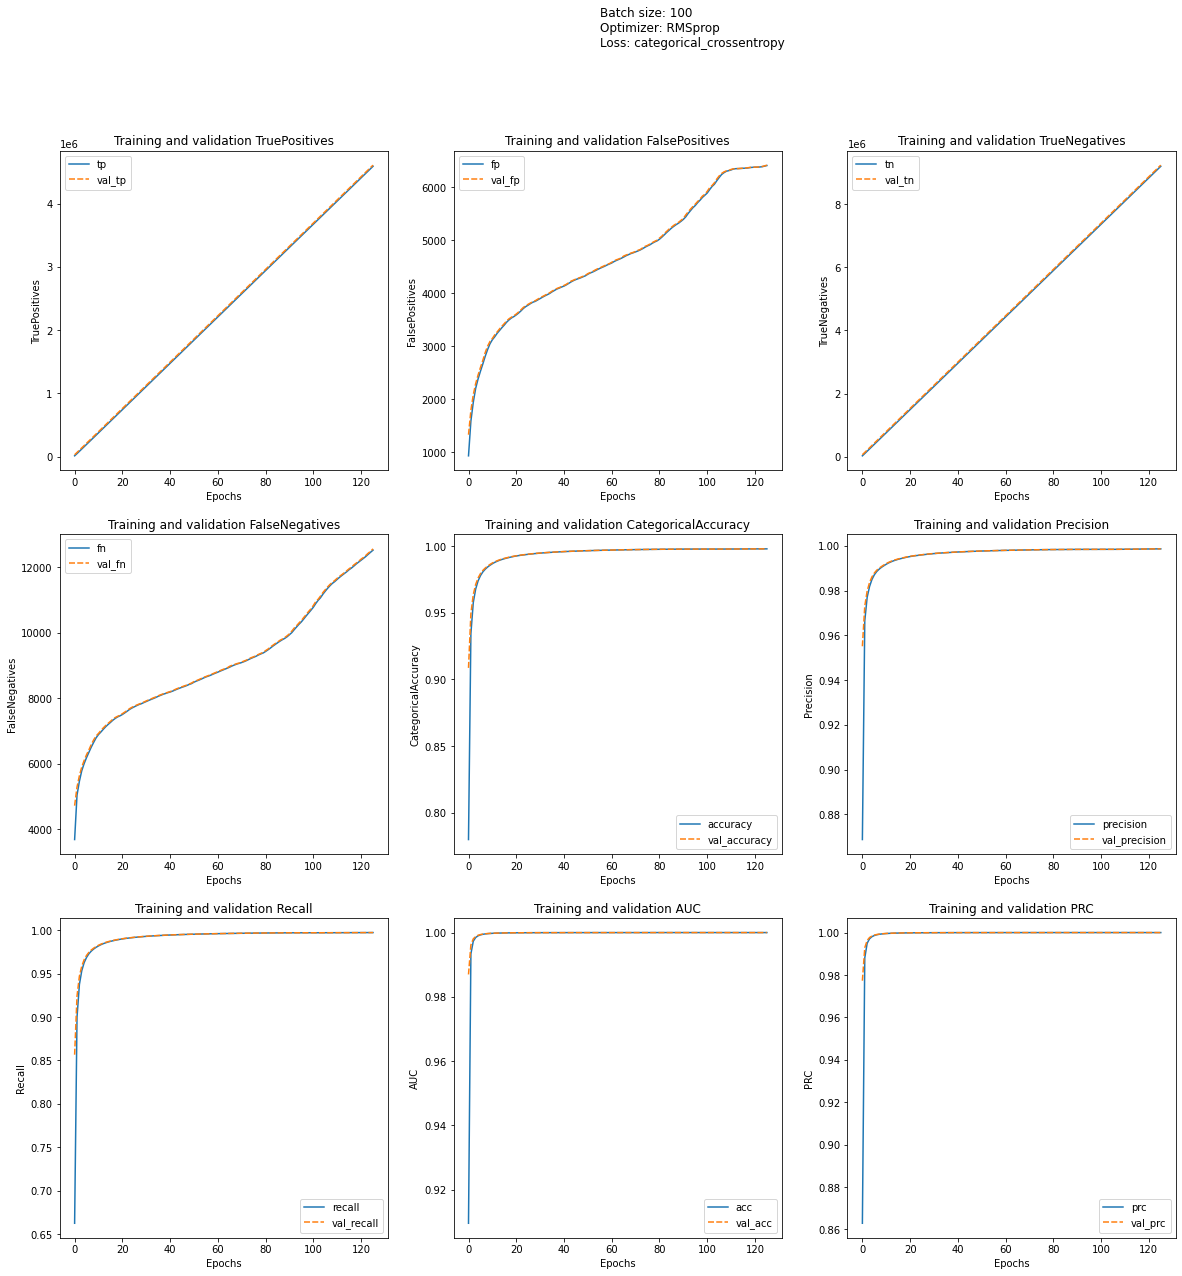

In [21]:
plots = [
           {'cols':['tp', 'val_tp'], 'title':'Training and validation TruePositives', 'yLabel':'TruePositives'},
           {'cols':['fp', 'val_fp'], 'title':'Training and validation FalsePositives', 'yLabel':'FalsePositives'},
           {'cols':['tn', 'val_tn'], 'title':'Training and validation TrueNegatives', 'yLabel':'TrueNegatives'},
           {'cols':['fn', 'val_fn'], 'title':'Training and validation FalseNegatives', 'yLabel':'FalseNegatives'},
           {'cols':['accuracy', 'val_accuracy'], 'title':'Training and validation CategoricalAccuracy', 'yLabel':'CategoricalAccuracy'},
           {'cols':['precision', 'val_precision'], 'title':'Training and validation Precision', 'yLabel':'Precision'},
           {'cols':['recall', 'val_recall'], 'title':'Training and validation Recall', 'yLabel':'Recall'},
           {'cols':['acc', 'val_acc'], 'title':'Training and validation AUC', 'yLabel':'AUC'},
           {'cols':['prc', 'val_prc'], 'title':'Training and validation PRC', 'yLabel':'PRC'} # precision-recall curve
]

fig = plt.figure(figsize=(20,20))
fig_no = 331
title = 'Batch size: {}\nOptimizer: {}\nLoss: {}'.format(batch_size,optimizer._name, loss)
fig.suptitle(title, fontsize="large", horizontalalignment='left', verticalalignment='top')

for i in range(len(plots)):
    ax = fig.add_subplot(str(fig_no))
    sns.lineplot(data=training_history[plots[i]['cols']], ax=ax)
    plt.title(plots[i]['title'])
    plt.xlabel('Epochs')
    plt.ylabel(plots[i]['yLabel'])
    fig_no += 1

plt.show()

### Predictions

### Overall Performance

In [22]:
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, f1_score, confusion_matrix

predictions = model.predict( x=X_test, verbose=1 )
predictions = pd.DataFrame(predictions.round().astype(int), columns=['is_End',	'is_None',	'is_Start'])

print('Accuracy: ', accuracy_score(y_test, predictions)*100)
print('AP: ', average_precision_score(y_test, predictions, average='samples'))
print('Recall: ', recall_score(y_test, predictions, average='samples'))
print('F1 score: ', f1_score(y_test, predictions, average='samples'))

confusion_matrix(y_test.argmax(axis=1), predictions.values.argmax(axis=1))

287/287 [==============================] - 0s 394us/step
Accuracy:  100.0
AP:  1.0
Recall:  1.0
F1 score:  1.0


array([[2135,    0,    0],
       [   0, 4645,    0],
       [   0,    0, 2393]])

### Start and End Performance

In [23]:
predictions = model.predict( x=X_test, verbose=1 )
predictions = pd.DataFrame(predictions.round().astype(int), columns=['is_End',	'is_None',	'is_Start'])
bool_test_not_none = np.array(y_test[:, 1] != 1)
y_prod = pd.DataFrame(predictions[bool_test_not_none])
y_true = pd.DataFrame(y_test[bool_test_not_none])

print('Accuracy: ', accuracy_score(y_true, y_prod)*100)
print('AP: ', average_precision_score(y_true, y_prod, average='samples'))
print('Recall: ', recall_score(y_true, y_prod, average='samples'))
print('F1 score: ', f1_score(y_true, y_prod, average='samples'))

confusion_matrix(y_true.values.argmax(axis=1), y_prod.values.argmax(axis=1))

287/287 [==============================] - 0s 598us/step
Accuracy:  100.0
AP:  1.0
Recall:  1.0
F1 score:  1.0


array([[2135,    0],
       [   0, 2393]])